
#  Milestone–2: Feature Engineering & Player Performance Modeling

## Objective
This milestone builds upon **Milestone–1 (cleaned ball-by-ball data)** to:
- Engineer player-level batting & bowling features
- Analyze recent player form
- Prepare ML-ready datasets
- Train and evaluate a baseline machine learning model


##  1. Imports & Configuration

In [51]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)


## 2. Load Cleaned Data from Milestone–1

In [52]:
from pathlib import Path

DATA_ROOT = Path(r"D:\Ball_By_Ball Data")
CLEAN_DATA_PATH = DATA_ROOT / "processed" / "deliveries_clean.parquet"

print("File exists:", CLEAN_DATA_PATH.exists())

df = pd.read_parquet(CLEAN_DATA_PATH)
df.head()


File exists: True


,league,match_id,venue,innings,ball,batting_team,batter,bowler,runs_batter,runs_extras,runs_total,wicket
0,ipl,1082591,"Rajiv Gandhi International Stadium, Uppal",1,0.1,Sunrisers Hyderabad,DA Warner,TS Mills,0,0,0,0
1,ipl,1082591,"Rajiv Gandhi International Stadium, Uppal",1,0.2,Sunrisers Hyderabad,DA Warner,TS Mills,0,0,0,0
2,ipl,1082591,"Rajiv Gandhi International Stadium, Uppal",1,0.3,Sunrisers Hyderabad,DA Warner,TS Mills,4,0,4,0
3,ipl,1082591,"Rajiv Gandhi International Stadium, Uppal",1,0.4,Sunrisers Hyderabad,DA Warner,TS Mills,0,0,0,0
4,ipl,1082591,"Rajiv Gandhi International Stadium, Uppal",1,0.5,Sunrisers Hyderabad,DA Warner,TS Mills,0,2,2,0


In [53]:

if "batsman" in df.columns:
    df = df.rename(columns={"batsman": "batter"})

print(df.columns.tolist())


['league', 'match_id', 'venue', 'innings', 'ball', 'batting_team', 'batter', 'bowler', 'runs_batter', 'runs_extras', 'runs_total', 'wicket']


##  3. Feature Engineering – Batting Performance

In [54]:

batting_features = df.groupby("batter").agg(
    balls_faced=("runs_batter", "count"),
    total_runs=("runs_batter", "sum"),
    fours=("runs_batter", lambda x: (x == 4).sum()),
    sixes=("runs_batter", lambda x: (x == 6).sum()),
    dismissals=("wicket", "sum")
).reset_index()

batting_features["strike_rate"] = (
    batting_features["total_runs"] / batting_features["balls_faced"]
) * 100

batting_features["average"] = (
    batting_features["total_runs"] / batting_features["dismissals"].replace(0, np.nan)
)

batting_features.fillna(0, inplace=True)
batting_features.head()


,batter,balls_faced,total_runs,fours,sixes,dismissals,strike_rate,average
0,A Ashish Reddy,196,280,16,15,15,142.857143,18.666667
1,A Badoni,740,963,73,38,36,130.135135,26.750000
2,A Chandila,7,4,0,0,1,57.142857,4.000000
3,A Chopra,75,53,7,0,5,70.666667,10.600000
4,A Choudhary,20,25,1,1,2,125.000000,12.500000


In [55]:
print(df.columns.tolist())


['league', 'match_id', 'venue', 'innings', 'ball', 'batting_team', 'batter', 'bowler', 'runs_batter', 'runs_extras', 'runs_total', 'wicket']


In [56]:
print("Shape:", df.shape)
print(df.head())


Shape: (278205, 12)
  league match_id                                      venue  innings  ball  \
0    ipl  1082591  Rajiv Gandhi International Stadium, Uppal        1   0.1   
1    ipl  1082591  Rajiv Gandhi International Stadium, Uppal        1   0.2   
2    ipl  1082591  Rajiv Gandhi International Stadium, Uppal        1   0.3   
3    ipl  1082591  Rajiv Gandhi International Stadium, Uppal        1   0.4   
4    ipl  1082591  Rajiv Gandhi International Stadium, Uppal        1   0.5   

          batting_team     batter    bowler  runs_batter  runs_extras  \
0  Sunrisers Hyderabad  DA Warner  TS Mills            0            0   
1  Sunrisers Hyderabad  DA Warner  TS Mills            0            0   
2  Sunrisers Hyderabad  DA Warner  TS Mills            4            0   
3  Sunrisers Hyderabad  DA Warner  TS Mills            0            0   
4  Sunrisers Hyderabad  DA Warner  TS Mills            0            2   

   runs_total  wicket  
0           0       0  
1           0     

##  4. Feature Engineering – Bowling Performance

In [57]:

bowling_features = df.groupby("bowler").agg(
    balls_bowled=("runs_total", "count"),
    runs_conceded=("runs_total", "sum"),
    wickets_taken=("wicket", "sum")
).reset_index()

bowling_features["economy"] = (
    bowling_features["runs_conceded"] / (bowling_features["balls_bowled"] / 6)
)

bowling_features["bowling_average"] = (
    bowling_features["runs_conceded"] / bowling_features["wickets_taken"].replace(0, np.nan)
)

bowling_features.fillna(0, inplace=True)
bowling_features.head()


,bowler,balls_bowled,runs_conceded,wickets_taken,economy,bowling_average
0,A Ashish Reddy,270,400,19,8.888889,21.052632
1,A Badoni,35,50,4,8.571429,12.500000
2,A Chandila,234,245,11,6.282051,22.272727
3,A Choudhary,108,144,5,8.000000,28.800000
4,A Dananjaya,25,47,0,11.280000,0.000000


In [58]:
# Create a safe numeric time index (no datetime overflow)
df = df.reset_index(drop=True)
df["time_index"] = df.index


##  5. Player Form Analysis

In [59]:
# Reset index to ensure proper sequence
df = df.reset_index(drop=True)

# Rolling recent form based on last 50 balls per batter
recent_form = (
    df.groupby("batter")["runs_batter"]
      .rolling(window=50)
      .mean()
      .reset_index()
      .rename(columns={"runs_batter": "recent_50_ball_avg"})
)

recent_form.head()


,batter,level_1,recent_50_ball_avg
0,A Ashish Reddy,209358,NaN
1,A Ashish Reddy,209359,NaN
2,A Ashish Reddy,209360,NaN
3,A Ashish Reddy,209361,NaN
4,A Ashish Reddy,209363,NaN


##  6. Target Variable Creation

In [60]:

batting_features["impact_player"] = (
    batting_features["strike_rate"] > 130
).astype(int)

batting_features[["batter", "strike_rate", "impact_player"]].head()


,batter,strike_rate,impact_player
0,A Ashish Reddy,142.857143,1
1,A Badoni,130.135135,1
2,A Chandila,57.142857,0
3,A Chopra,70.666667,0
4,A Choudhary,125.000000,0


##  7. ML Dataset Preparation

In [61]:

features = batting_features[
    ["balls_faced", "total_runs", "strike_rate", "average"]
]

target = batting_features["impact_player"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


##  8. Model Training

In [62]:

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


##  9. Model Evaluation

Accuracy: 0.9929078014184397

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       106
           1       1.00      0.97      0.99        35

    accuracy                           0.99       141
   macro avg       1.00      0.99      0.99       141
weighted avg       0.99      0.99      0.99       141



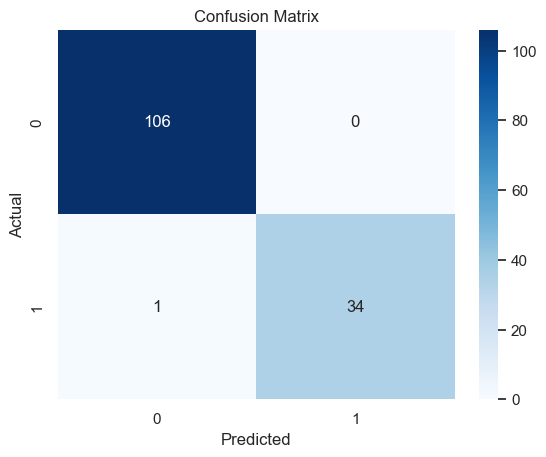

In [63]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 10. Distribution of Runs per Ball

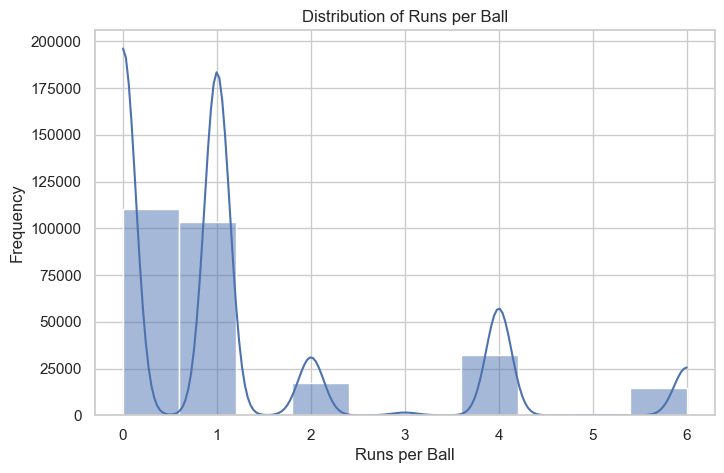

In [64]:
plt.figure(figsize=(8,5))
sns.histplot(df["runs_batter"], bins=10, kde=True)
plt.title("Distribution of Runs per Ball")
plt.xlabel("Runs per Ball")
plt.ylabel("Frequency")
plt.show()


## 11.Top 15 Batters by Total Runs

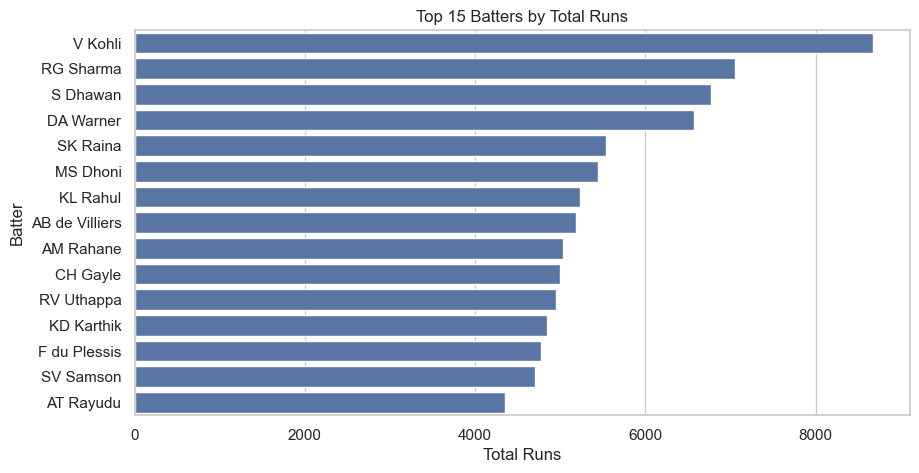

In [65]:
top_batters = (
    batting_features
    .sort_values("total_runs", ascending=False)
    .head(15)
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=top_batters,
    x="total_runs",
    y="batter"
)
plt.title("Top 15 Batters by Total Runs")
plt.xlabel("Total Runs")
plt.ylabel("Batter")
plt.show()


## 12. Strike Rate vs Average (Key Performance Plot)

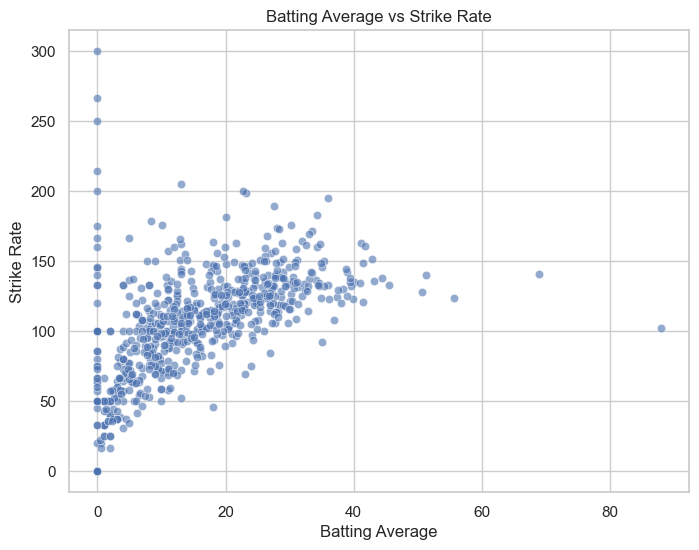

In [66]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=batting_features,
    x="average",
    y="strike_rate",
    alpha=0.6
)
plt.title("Batting Average vs Strike Rate")
plt.xlabel("Batting Average")
plt.ylabel("Strike Rate")
plt.show()


## 13. Recent Form Distribution (Rolling 50 Balls)

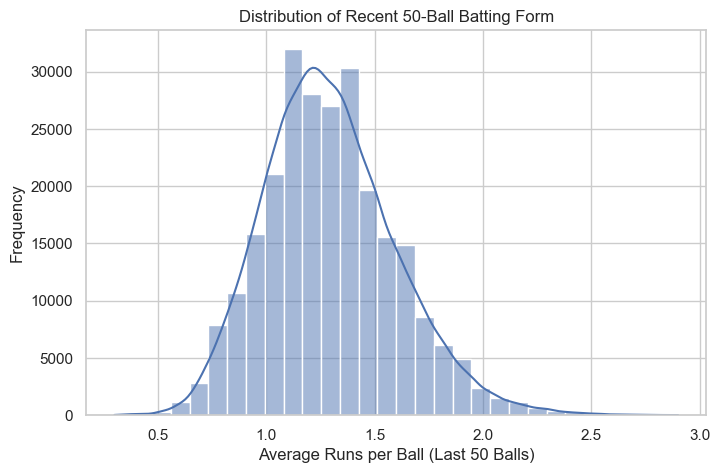

In [67]:
plt.figure(figsize=(8,5))
sns.histplot(
    recent_form["recent_50_ball_avg"].dropna(),
    bins=30,
    kde=True
)
plt.title("Distribution of Recent 50-Ball Batting Form")
plt.xlabel("Average Runs per Ball (Last 50 Balls)")
plt.ylabel("Frequency")
plt.show()


## 14. Boundary Contribution (Fours vs Sixes)

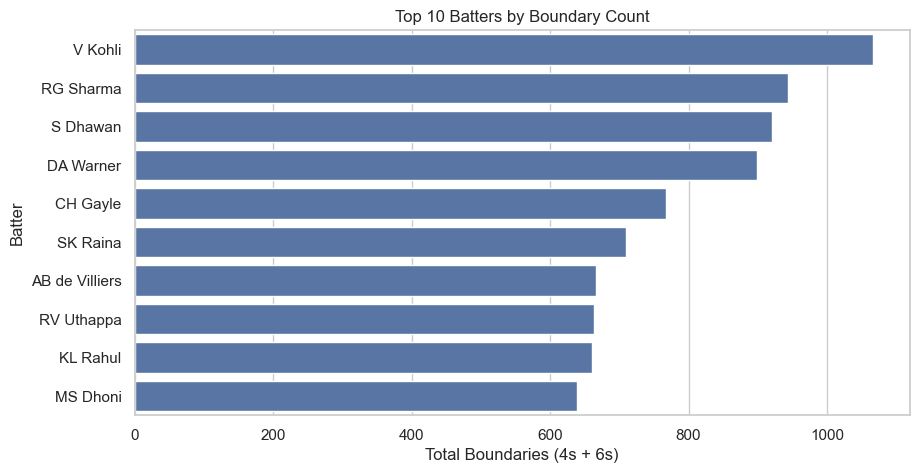

In [68]:
boundary_df = batting_features.copy()
boundary_df["boundaries"] = boundary_df["fours"] + boundary_df["sixes"]

top_boundary = boundary_df.sort_values("boundaries", ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(
    data=top_boundary,
    x="boundaries",
    y="batter"
)
plt.title("Top 10 Batters by Boundary Count")
plt.xlabel("Total Boundaries (4s + 6s)")
plt.ylabel("Batter")
plt.show()



## ✅ Milestone–2 Completed

✔ Feature engineering completed  
✔ Player form analysis implemented  
✔ ML model trained & evaluated  

🔜 Next: Advanced models & dashboard
